In [1]:
import gpboost as gpb
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
plt.style.use('ggplot')

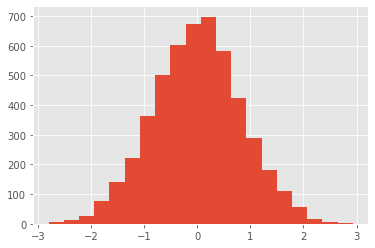

In [3]:
def f1d(x):
    """Non-linear fixed effects function for simulation"""
    return 1 / (1 + np.exp(-(x - 0.5) * 10)) - 0.5

def simulate_response_variable(lp, rand_eff, likelihood):
    """Function that simulates response variable for various likelihoods"""
    n = len(rand_eff)
    if likelihood == "gaussian":
        xi = 0.25 * np.random.normal(size=n) # error term
        y = lp + rand_eff + xi
    elif likelihood == "bernoulli_probit":
        probs = stats.norm.cdf(lp + rand_eff)
        y = np.random.uniform(size=n) < probs
        y = y.astype(np.float64)
    elif likelihood == "bernoulli_logit":
        probs = 1 / (1 + np.exp(-(lp + rand_eff)))
        y = np.random.uniform(size=n) < probs
        y = y.astype(np.float64)
    elif likelihood == "poisson":
        mu = np.exp(lp + rand_eff)
        y = stats.poisson.ppf(np.random.uniform(size=n), mu=mu)
    elif likelihood == "gamma":
        mu = np.exp(lp + rand_eff)
        y = mu * stats.gamma.ppf(np.random.uniform(size=n), a=1)
    return y

# Choose likelihood: either "gaussian" (=regression), 
#                     "bernoulli_probit", "bernoulli_logit", (=classification)
#                     "poisson", or "gamma"
likelihood = "gaussian"

"""
Combine tree-boosting and grouped random effects model
"""
# --------------------Simulate data----------------
n = 5000  # number of samples
m = 500  # number of groups
np.random.seed(1)
# Simulate grouped random effects
group = np.arange(n)  # grouping variable
for i in range(m):
    group[int(i * n / m):int((i + 1) * n / m)] = i
b1 = np.sqrt(0.5) * np.random.normal(size=m)  # simulate random effects
rand_eff = b1[group]
rand_eff = rand_eff - np.mean(rand_eff)
# Simulate fixed effects
p = 5 # number of predictor variables
X = np.random.rand(n, p)
f = f1d(X[:, 0])
y = simulate_response_variable(lp=f, rand_eff=rand_eff, likelihood=likelihood)
hst = plt.hist(y, bins=20)  # visualize response variable
plt.show(block=False)

# Specify boosting parameters as dict
params = {'objective': likelihood, 'learning_rate': 0.01, 'max_depth': 3,
          'verbose': 0}
num_boost_round = 250
if likelihood == "gaussian":
    num_boost_round = 50
    params['objective'] = 'regression_l2'
if likelihood in ("bernoulli_probit", "bernoulli_logit"):
    num_boost_round = 500
    params['objective'] = 'binary'
# Note: these parameters are not necessarily optimal for all situations considered here

In [4]:
#--------------------Training----------------
# Define random effects model
gp_model = gpb.GPModel(group_data=group, likelihood=likelihood)
# The default optimizer for covariance parameters (hyperparameters) is Nesterov-accelerated gradient descent.
# This can be changed to, e.g., Nelder-Mead as follows:
# gp_model.set_optim_params(params={"optimizer_cov": "nelder_mead"})
# Use the option "trace": true to monitor convergence of hyperparameter estimation of the gp_model. E.g.:
# gp_model.set_optim_params(params={"trace": True})

# Create dataset for gpb.train
data_train = gpb.Dataset(X, y)
bst = gpb.train(params=params, train_set=data_train,  gp_model=gp_model,
                num_boost_round=num_boost_round)
gp_model.summary() # Estimated random effects model

: 

: 

In [1]:
import torch